In [ ]:
#!pip install super-gradients==3.7.1

In [ ]:
# connect to google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Directories to image files and annotation folder
file_dir = '/content/gdrive/MyDrive/Colab Notebooks/GC-10/IMAGES'
xml_annotation_dir = '/content/gdrive/MyDrive/Colab Notebooks/GC-10/ANNOTATIONS'

In [ ]:
# Import required python basic packages
import os
import random
import numpy as np
import pandas as pd
import glob

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Import opencv
import cv2

# XML library for parsing xml files
from xml.etree import ElementTree as et

# matplotlib for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# torchutils library
from torch.utils.data import DataLoader, random_split

from pathlib import Path
import requests
from PIL import Image
import torch

from super_gradients.training import Trainer, dataloaders, models
from super_gradients.training.dataloaders.dataloaders import (
    coco_detection_yolo_format_train, coco_detection_yolo_format_val
)
from super_gradients.training.losses import PPYoloELoss
from super_gradients.training.metrics import DetectionMetrics_050
from super_gradients.training.models.detection_models.pp_yolo_e import (
    PPYoloEPostPredictionCallback
)

[2024-11-07 04:16:33] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


In [ ]:
# import required module
from PIL import Image

# get image
filepath = "/content/gdrive/MyDrive/Colab Notebooks/GC-10/IMAGES/crease/img_01_425382900_00002.jpg"
img = Image.open(filepath)

# get width and height
get_width = img.width
get_height = img.height

# display width and height
print("The height of the image is: ", get_height)
print("The width of the image is: ", get_width)

In [ ]:
# import random
# import shutil

# base_dir = '/content/gdrive/MyDrive/Colab Notebooks/GC-10'

# # path to destination image folders
# train_folder = os.path.join(base_dir, 'train_images')
# val_folder = os.path.join(base_dir, 'val_images')
# test_folder = os.path.join(base_dir, 'test_images')

# # path to destination annotation folders
# train_annotation_folder = os.path.join(base_dir, 'train_annotations')
# val_annotation_folder = os.path.join(base_dir, 'val_annotations')
# test_annotation_folder = os.path.join(base_dir, 'test_annotations')

# # Define a list of image extensions
# image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']

# # Create a list of image filenames in 'data_path'
# imgs_list = glob.glob(os.path.join(file_dir, '**/*.jpg'), recursive=True)
# # Sets the random seed
# random.seed(42)

# # Shuffle the list of image filenames
# random.shuffle(imgs_list)

# # determine the number of images for each set
# train_size = int(len(imgs_list) * 0.7)
# val_size = int(len(imgs_list) * 0.15)
# test_size = int(len(imgs_list) * 0.15)

# print(imgs_list)

# # Create destination folders if they don't exist
# for folder_path in [train_folder, val_folder, test_folder, train_annotation_folder, val_annotation_folder, test_annotation_folder]:
#     if not os.path.exists(folder_path):
#         print(f"Creating folder: {folder_path}")
#         os.makedirs(folder_path)
# count = 0
# # Copy image files to destination folders
# for i, f in enumerate(imgs_list):
#     # Construct the image path
#     img_path = os.path.join(file_dir, f)

#     img_filename = os.path.splitext(os.path.basename(img_path))[0] + '.jpg'

#     # Construct the corresponding XML file path based on the relative structure
#     xml_filename = os.path.splitext(os.path.basename(img_path))[0] + '.xml'
#     xml_path = os.path.join(xml_annotation_dir, xml_filename)

#     if not os.path.exists(xml_path):
#         #print(f"Warning: Annotation file for {f} does not exist!")
#         count += 1
#         continue
#     else:
#       if i < train_size:
#         dest_folder = train_folder
#         dest_annotation_folder = train_annotation_folder
#       elif i < train_size + val_size:
#         dest_folder = val_folder
#         dest_annotation_folder = val_annotation_folder
#       else:
#         dest_folder = test_folder
#         dest_annotation_folder = test_annotation_folder

#     shutil.copy(img_path, os.path.join(dest_folder, img_filename))
#     shutil.copy(xml_path, os.path.join(dest_annotation_folder, xml_filename))

['/content/gdrive/MyDrive/Colab Notebooks/GC-10/IMAGES/welding_line/img_06_425502900_00052.jpg', '/content/gdrive/MyDrive/Colab Notebooks/GC-10/IMAGES/water_spot/img_03_424992500_01054.jpg', '/content/gdrive/MyDrive/Colab Notebooks/GC-10/IMAGES/silk_spot/img_08_4406743300_00413.jpg', '/content/gdrive/MyDrive/Colab Notebooks/GC-10/IMAGES/oil_spot/img_08_425391700_00189.jpg', '/content/gdrive/MyDrive/Colab Notebooks/GC-10/IMAGES/silk_spot/img_01_425005700_00446.jpg', '/content/gdrive/MyDrive/Colab Notebooks/GC-10/IMAGES/punching_hole/img_06_3403399400_01044.jpg', '/content/gdrive/MyDrive/Colab Notebooks/GC-10/IMAGES/water_spot/img_02_4403466200_00006.jpg', '/content/gdrive/MyDrive/Colab Notebooks/GC-10/IMAGES/silk_spot/img_01_425005700_00266.jpg', '/content/gdrive/MyDrive/Colab Notebooks/GC-10/IMAGES/water_spot/img_02_4406772100_00887.jpg', '/content/gdrive/MyDrive/Colab Notebooks/GC-10/IMAGES/welding_line/img_06_425613800_00787.jpg', '/content/gdrive/MyDrive/Colab Notebooks/GC-10/IMAGES

In [ ]:
from typing import Dict, Union
def convert_xml_to_yolo(xml_folder: Union[str, Path], output_folder: Union[str, Path], class_mapping: Dict[str, int]) -> None:
    """
    Convert XML annotations to YOLO format.

    Parameters:
    - xml_folder (Union[str, Path]): Path to the folder containing the XML annotation files.
    - output_folder (Union[str, Path]): Path to the folder where the YOLO annotation files will be saved.
    - class_mapping (Dict[str, int]): Dictionary mapping class names to integer class indices.

    Returns:
    None
    """
    # Convert the input folders to Path objects
    xml_folder = Path(xml_folder)
    output_folder = Path(output_folder)

    # Create the output folder if it does not exist
    output_folder.mkdir(parents=True, exist_ok=True)

    # Iterate through the files in the xml_folder
    for xml_file in xml_folder.glob("*.xml"):
        # Parse the XML file
        tree = et.parse(xml_file)
        root = tree.getroot()

        # Get the image size
        size = root.find("size")
        img_width = int(size.find("width").text)
        img_height = int(size.find("height").text)

        # Create a new text file for the YOLO annotations
        yolo_filename = xml_file.with_suffix(".txt").name
        yolo_file_path = output_folder / yolo_filename
        with open(yolo_file_path, "w") as yolo_file:
            for obj in root.iter("object"):
                # Get the class name and index
                class_name = obj.find("name").text
                if class_name not in class_mapping:
                    print(f"Warning: Class '{class_name}' not found in the mapping. Skipping.")
                    continue
                class_index = class_mapping[class_name]

                # Get the bounding box coordinates
                box = obj.find("bndbox")
                xmin = int(box.find("xmin").text)
                ymin = int(box.find("ymin").text)
                xmax = int(box.find("xmax").text)
                ymax = int(box.find("ymax").text)

                # Calculate the YOLO-format coordinates and dimensions
                x_center = (xmin + xmax) / 2 / img_width
                y_center = (ymin + ymax) / 2 / img_height
                width = (xmax - xmin) / img_width
                height = (ymax - ymin) / img_height

                # Write the annotation in YOLO format
                yolo_file.write(f"{class_index} {x_center} {y_center} {width} {height}\n")

class_mapping = {
    "1_chongkong": 1,
    "2_hanfeng": 2,
    "3_yueyawan": 3,
    "4_shuiban": 4,
    "5_youban": 5,
    "6_siban": 6,
    "7_yiwu": 7,
    "8_yahen": 8,
    "9_zhehen": 9,
    "10_yaozhed": 10,
    "10_yaozhe" : 10
}

In [ ]:
# Convert the XML annotations to YOLOv5 format
base_dir = '/content/gdrive/MyDrive/Colab Notebooks/GC-10'

xml_train_folder = os.path.join(base_dir, 'train_annotations')
output_train_folder = os.path.join(base_dir, 'train_annotations_yolo')

xml_val_folder = os.path.join(base_dir, 'val_annotations')
output_val_folder = os.path.join(base_dir, 'val_annotations_yolo')

convert_xml_to_yolo(xml_folder=xml_train_folder, output_folder=output_train_folder,
                    class_mapping=class_mapping)

convert_xml_to_yolo(xml_folder=xml_val_folder, output_folder=output_val_folder,
                    class_mapping=class_mapping)

In [ ]:
class config:
    #trainer params
    CHECKPOINT_DIR = '/content/gdrive/MyDrive/Colab Notebooks/YOLO/YOLO NAS/checkpoints' #specify the path you want to save checkpoints to
    EXPERIMENT_NAME = 'GC-10 defect-detection' #specify the experiment name

    #dataset params
    DATA_DIR = '.' #parent directory to where data lives

    TRAIN_IMAGES_DIR = os.path.join(base_dir, 'train_images') #child dir of DATA_DIR where train images are
    TRAIN_LABELS_DIR = os.path.join(base_dir, 'train_annotations_yolo') #child dir of DATA_DIR where train labels are

    VAL_IMAGES_DIR = os.path.join(base_dir, 'val_images') #child dir of DATA_DIR where validation images are
    VAL_LABELS_DIR = os.path.join(base_dir, 'val_annotations_yolo') #child dir of DATA_DIR where validation labels are


    CLASSES = list(class_mapping.keys()) #what class names do you have

    NUM_CLASSES = len(CLASSES)

    #dataloader params - you can add whatever PyTorch dataloader params you have
    #could be different across train, val, and test
    DATALOADER_PARAMS={
    'batch_size':16,
    'num_workers':2
    }

    # model params
    MODEL_NAME = 'yolo_nas_l' # choose from yolo_nas_s, yolo_nas_m, yolo_nas_l
    PRETRAINED_WEIGHTS = 'coco' #only one option here: coco

In [ ]:
trainer = Trainer(experiment_name=config.EXPERIMENT_NAME, ckpt_root_dir=config.CHECKPOINT_DIR)

In [ ]:
train_data = coco_detection_yolo_format_train(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.TRAIN_IMAGES_DIR,
        'labels_dir': config.TRAIN_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

val_data = coco_detection_yolo_format_val(
    dataset_params={
        'data_dir': config.DATA_DIR,
        'images_dir': config.VAL_IMAGES_DIR,
        'labels_dir': config.VAL_LABELS_DIR,
        'classes': config.CLASSES
    },
    dataloader_params=config.DATALOADER_PARAMS
)

[2024-11-07 06:16:58] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 1597/1597 [00:23<00:00, 67.62it/s] 
[2024-11-07 06:17:22] INFO - detection_dataset.py - Dataset Initialization in progress. `cache_annotations=True` causes the process to take longer due to full dataset indexing.
Indexing dataset annotations: 100%|██████████| 342/342 [00:03<00:00, 106.55it/s]


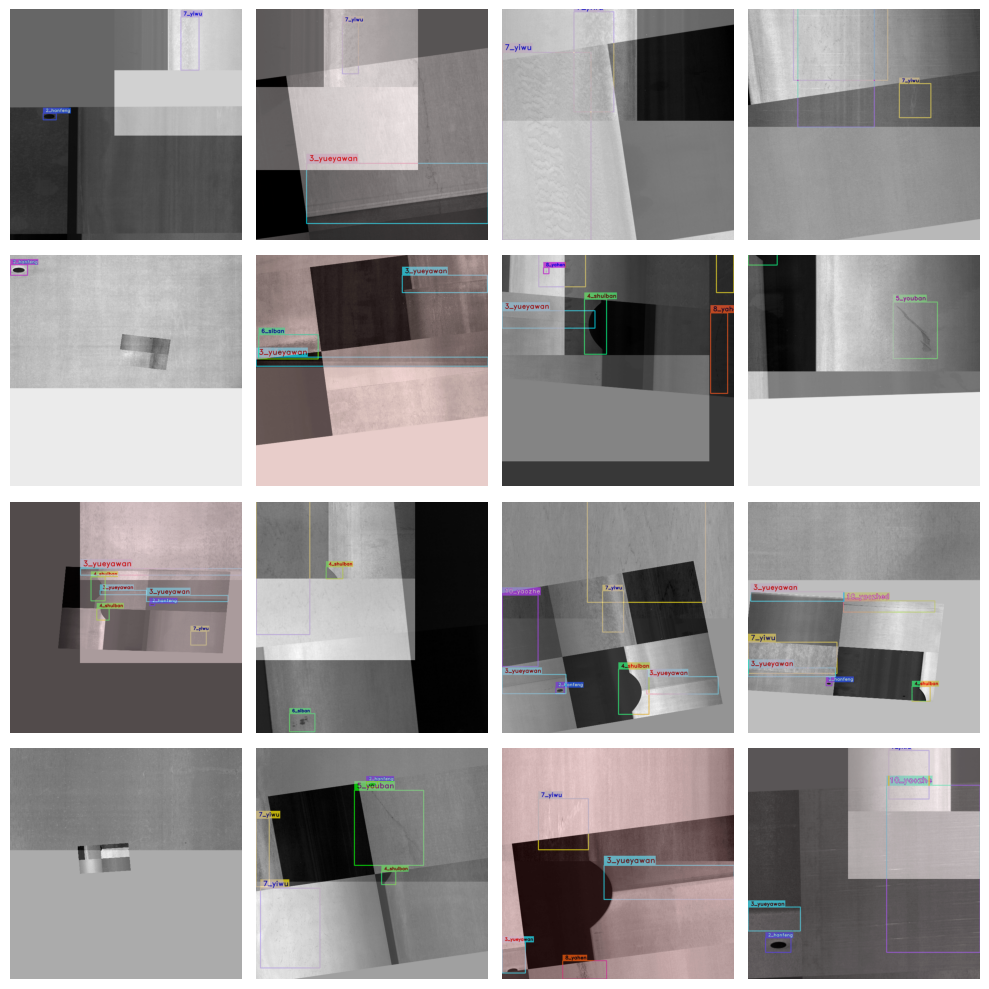

In [ ]:
train_data.dataset.plot()

In [ ]:
!apt-get update && apt-get install -y iputils-ping
# Check internet connection
!ping -c 4 google.com

# Check DNS resolution by pinging the domain used in the URL for downloading weights
!ping -c 4 download.pytorch.org # Example domain, replace if necessary


Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:5 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:9 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,397 kB]
Get:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,163 kB]
Get:12 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3,241 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-

In [ ]:
model = models.get(config.MODEL_NAME,
                   num_classes=config.NUM_CLASSES,
                   pretrained_weights=config.PRETRAINED_WEIGHTS
                   )

[2024-11-07 06:31:40] WARNING - checkpoint_utils.py - :warning: The pre-trained models provided by SuperGradients may have their own licenses or terms and conditions derived from the dataset used for pre-training.
 It is your responsibility to determine whether you have permission to use the models for your use case.
 The model you have requested was pre-trained on the coco dataset, published under the following terms: https://cocodataset.org/#termsofuse
[2024-11-07 06:31:40] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.


URLError: <urlopen error [Errno -2] Name or service not known>

Downloading: "https://sghub.deci.ai/models/yolo_nas_l_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_l_coco.pth
